# nsfw text detector

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Text processing
import re


# ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


# Data Load and EDA

In [2]:
# Load datasets
train_df = pd.read_csv('./Data/train.csv.zip')
test_df = pd.read_csv('./Data/test.csv.zip')
# sample_submission = pd.read_csv('./Data/sample_submission.csv.zip')

# Define target columns
TARGET_COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print("=== DATASET SHAPES ===")
print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")
# print(f"Submission: {sample_submission.shape}")


=== DATASET SHAPES ===
Train: (159571, 8)
Test: (153164, 2)


In [3]:
print("\n=== TRAIN DATASET INFO ===")
print(train_df.info())
print(f"\nColumns: {list(train_df.columns)}")


=== TRAIN DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None

Columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [4]:
print("\n=== MISSING VALUES ===")
print("Train missing values:")
print(train_df.isnull().sum())
print("\nTest missing values:")
print(test_df.isnull().sum())


=== MISSING VALUES ===
Train missing values:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Test missing values:
id              0
comment_text    0
dtype: int64


In [5]:
print("\n=== FIRST FEW SAMPLES ===")
train_df.head()


=== FIRST FEW SAMPLES ===


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
print("\n=== TARGET DISTRIBUTION ===")
target_counts = train_df[TARGET_COLUMNS].sum()
print(target_counts)
print(f"\nTotal comments: {len(train_df)}")


=== TARGET DISTRIBUTION ===
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

Total comments: 159571


=== TEXT LENGTH ANALYSIS ===
Train text length stats:
count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_length, dtype: float64

Test text length stats:
count    153164.000000
mean        364.875121
std         592.492099
min           1.000000
25%          79.000000
50%         180.000000
75%         392.000000
max        5000.000000
Name: text_length, dtype: float64


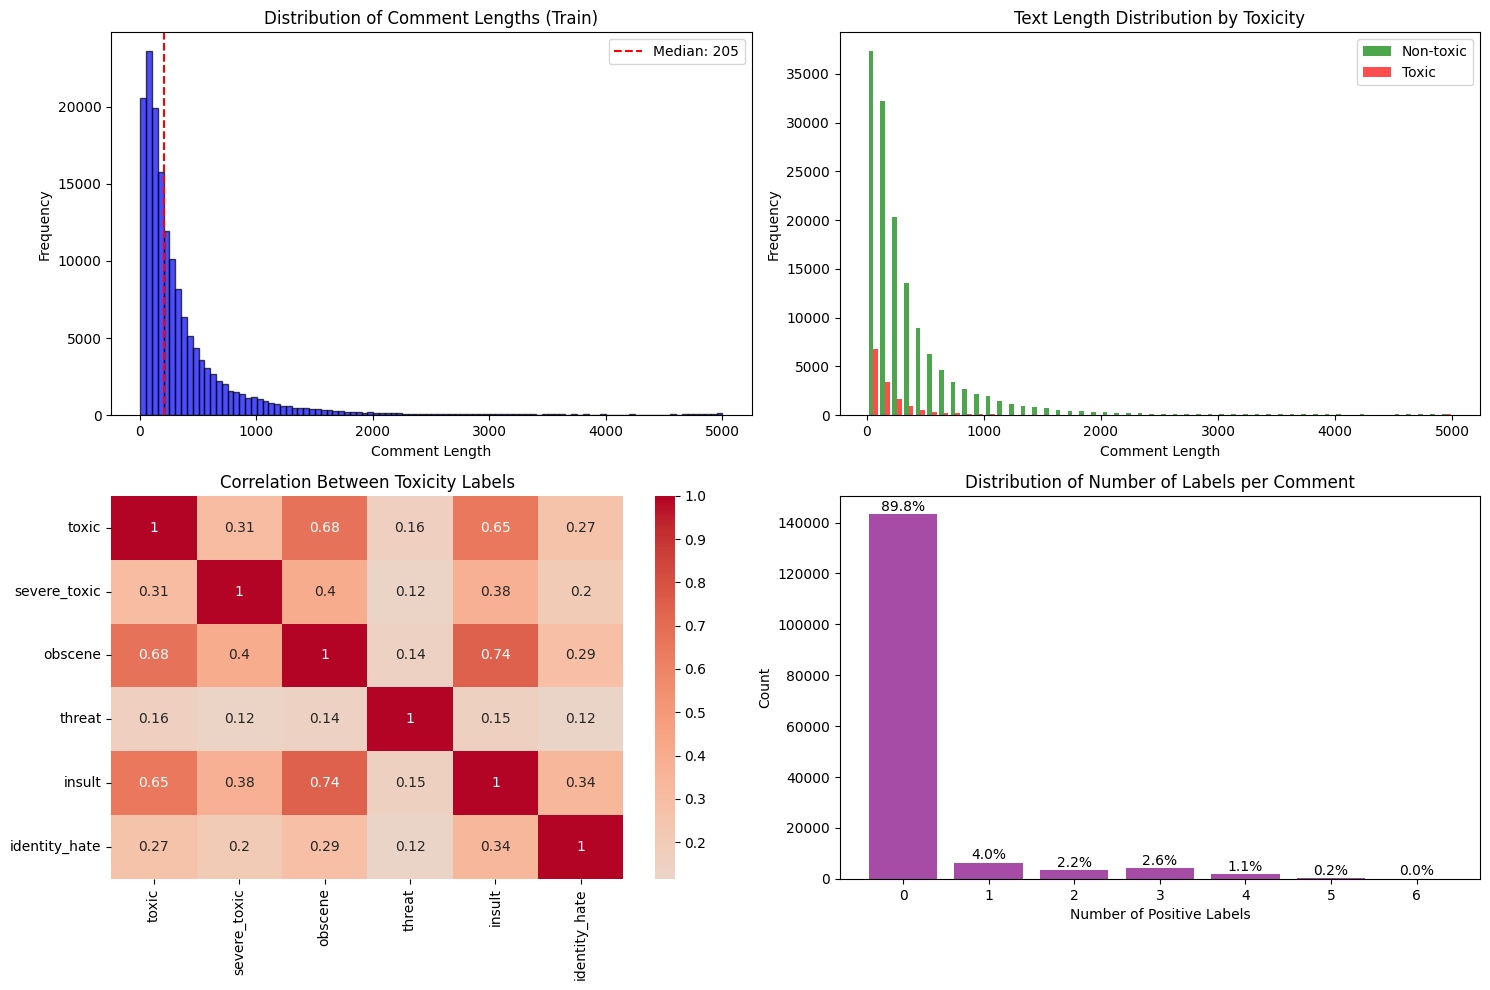

In [7]:
# === TEXT LENGTH ANALYSIS ===
print("=== TEXT LENGTH ANALYSIS ===")
train_df["text_length"] = train_df["comment_text"].str.len()
test_df["text_length"] = test_df["comment_text"].str.len()

print(f"Train text length stats:")
print(train_df["text_length"].describe())
print(f"\nTest text length stats:")
print(test_df["text_length"].describe())

# Visualization of text lengths
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall length distribution
axes[0, 0].hist(
    train_df["text_length"], bins=100, alpha=0.7, color="blue", edgecolor="black"
)
axes[0, 0].set_title("Distribution of Comment Lengths (Train)")
axes[0, 0].set_xlabel("Comment Length")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].axvline(
    train_df["text_length"].median(),
    color="red",
    linestyle="--",
    label=f'Median: {train_df["text_length"].median():.0f}',
)
axes[0, 0].legend()

# Length distribution by toxicity
toxic_lengths = train_df[train_df["toxic"] == 1]["text_length"]
non_toxic_lengths = train_df[train_df["toxic"] == 0]["text_length"]

axes[0, 1].hist(
    [non_toxic_lengths, toxic_lengths],
    bins=50,
    alpha=0.7,
    label=["Non-toxic", "Toxic"],
    color=["green", "red"],
)
axes[0, 1].set_title("Text Length Distribution by Toxicity")
axes[0, 1].set_xlabel("Comment Length")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].legend()

# === CLASS CORRELATION ANALYSIS ===
correlation_matrix = train_df[TARGET_COLUMNS].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, ax=axes[1, 0])
axes[1, 0].set_title("Correlation Between Toxicity Labels")

# === CO-OCCURRENCE ANALYSIS ===
# Count samples with multiple labels
multi_label_counts = train_df[TARGET_COLUMNS].sum(axis=1).value_counts().sort_index()
axes[1, 1].bar(
    multi_label_counts.index, multi_label_counts.values, color="purple", alpha=0.7
)
axes[1, 1].set_title("Distribution of Number of Labels per Comment")
axes[1, 1].set_xlabel("Number of Positive Labels")
axes[1, 1].set_ylabel("Count")

# Add percentage labels
total = len(train_df)
for i, v in enumerate(multi_label_counts.values):
    axes[1, 1].text(
        multi_label_counts.index[i],
        v + 100,
        f"{v/total*100:.1f}%",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

# Data PreProcessing

In [8]:
# === TEXT PREPROCESSING FUNCTIONS ===
def clean_text_basic(text):
    """Basic text cleaning for traditional ML models"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove newlines and extra spaces
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and special characters (but keep basic punctuation)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', ' ', text)
    
    return text.strip()

In [9]:
def clean_text_transformer(text):
    """Light cleaning for transformer models (they handle raw text better)"""
    if pd.isna(text):
        return ""
    
    # Convert to string and basic cleaning
    text = str(text)
    
    # Remove excessive newlines and spaces
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

In [10]:
# Apply preprocessing
print("=== PREPROCESSING TEXT ===")
print("Applying basic cleaning...")
train_df['comment_text_clean'] = train_df['comment_text'].apply(clean_text_basic)
test_df['comment_text_clean'] = test_df['comment_text'].apply(clean_text_basic)

print("Applying transformer-friendly cleaning...")
train_df['comment_text_transformer'] = train_df['comment_text'].apply(clean_text_transformer)
test_df['comment_text_transformer'] = test_df['comment_text'].apply(clean_text_transformer)

# Show examples of cleaning
print("\n=== CLEANING EXAMPLES ===")
examples = train_df.sample(3, random_state=42)
for idx, row in examples.iterrows():
    print(f"\nOriginal: {row['comment_text'][:100]}...")
    print(f"Basic cleaned: {row['comment_text_clean'][:100]}...")
    print(f"Transformer cleaned: {row['comment_text_transformer'][:100]}...")
    print("-" * 80)

=== PREPROCESSING TEXT ===
Applying basic cleaning...
Applying transformer-friendly cleaning...

=== CLEANING EXAMPLES ===

Original: Geez, are you forgetful!  We've already discussed why Marx  was  not an anarchist, i.e. he wanted to...
Basic cleaned: geez, are you forgetful! we ve already discussed why marx was not an anarchist, i.e. he wanted to us...
Transformer cleaned: Geez, are you forgetful! We've already discussed why Marx was not an anarchist, i.e. he wanted to us...
--------------------------------------------------------------------------------

Original: Carioca RFA 

Thanks for your support on my request for adminship.

The final outcome was (31/4/1), ...
Basic cleaned: carioca rfa thanks for your support on my request for adminship. the final outcome was  31 4 1 , so ...
Transformer cleaned: Carioca RFA Thanks for your support on my request for adminship. The final outcome was (31/4/1), so ...
------------------------------------------------------------------------------

# Data Splitting

In [11]:
# === STRATIFIED K-FOLD CREATION ===
print("\n=== CREATING STRATIFIED FOLDS ===")

# Install iterative-stratification if not available
try:
    from iterstrat import ml_stratifiers
except ImportError:
    print("Installing iterative-stratification...")
    !pip3 install iterative-stratification --quiet
    from iterstrat import ml_stratifiers


# Create stratified folds for multi-label
def create_folds(df, n_folds=5, random_state=42):
    """Create stratified folds for multi-label classification"""
    df_folds = df.copy()
    
    # Use iterative stratification for multi-label
    mskf = ml_stratifiers.MultilabelStratifiedKFold(
        n_splits=n_folds, shuffle=True, random_state=random_state
    )
    
    df_folds['fold'] = -1
    
    for fold, (_, val_idx) in enumerate(mskf.split(df_folds, df_folds[TARGET_COLUMNS])):
        df_folds.loc[val_idx, 'fold'] = fold
    
    return df_folds

# Create folds
train_df = create_folds(train_df, n_folds=5)

# Verify fold distribution
print("Fold distribution:")
print(train_df['fold'].value_counts().sort_index())



=== CREATING STRATIFIED FOLDS ===
Fold distribution:
fold
0    31914
1    31915
2    31914
3    31914
4    31914
Name: count, dtype: int64


# Model : 1 LOGISTIC REGRESSION 

In [13]:
# === BASELINE MODEL: TF-IDF + LOGISTIC REGRESSION ===

from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


def train_baseline_model(fold=0, model=None):
    """Train baseline model on specific fold"""

    # Get fold data
    train_idx = train_df[train_df["fold"] != fold].index
    val_idx = train_df[train_df["fold"] == fold].index

    X_train = train_df.loc[train_idx, "comment_text_clean"]
    X_val = train_df.loc[val_idx, "comment_text_clean"]
    y_train = train_df.loc[train_idx, TARGET_COLUMNS]
    y_val = train_df.loc[val_idx, TARGET_COLUMNS]

    print(f"Fold {fold}: Train size: {len(X_train)}, Val size: {len(X_val)}")

    # TF-IDF Vectorizer
    tfidf = TfidfVectorizer(
        max_features=50000,
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.9,
        strip_accents="unicode",
        use_idf=True,
        smooth_idf=True,
        sublinear_tf=True,
        stop_words="english",
    )

    if model is None:
        print("No model provided, please provide a valid model.")
        return None, None, None, None, None

    # Create pipeline
    pipeline = Pipeline([("tfidf", tfidf), ("classifier", model)])

    # Train model
    print(f"Training baseline model for fold {fold}...")
    pipeline.fit(X_train, y_train)

    # Predict probabilities
    train_preds = pipeline.predict_proba(X_train)
    val_preds = pipeline.predict_proba(X_val)

    # Extract probabilities for positive class (index 1)
    train_probs = np.column_stack([pred[:, 1] for pred in train_preds])
    val_probs = np.column_stack([pred[:, 1] for pred in val_preds])

    # Calculate metrics
    train_auc = roc_auc_score(y_train, train_probs, average="macro")
    val_auc = roc_auc_score(y_val, val_probs, average="macro")

    # Individual class AUCs
    train_aucs = roc_auc_score(y_train, train_probs, average=None)
    val_aucs = roc_auc_score(y_val, val_probs, average=None)

    # print(f"Fold {fold} Results:")

    # print("Classification Report")
    # print(
    #     classification_report(
    #         y_val, (val_probs > 0.6).astype(int), target_names=TARGET_COLUMNS
    #     )
    # )

    # print("Confusion Matrices:")
    # for i, col in enumerate(TARGET_COLUMNS):
    #     cm = confusion_matrix(y_val[col], (val_probs[:, i] > 0.5).astype(int))
    #     print(f"{col}:\n{cm}\n")

    # print(f"  Train AUC (macro): {train_auc:.4f}")
    # print(f"  Val AUC (macro): {val_auc:.4f}")

    score_dict = {}
    score_dict["fold"] = fold
    score_dict["train_auc"] = train_auc
    score_dict["val_auc"] = val_auc
    score_dict["val_aucs"] = val_aucs
    score_dict["train_aucs"] = train_aucs
    return pipeline, score_dict

In [14]:
# === CROSS-VALIDATION ===
print("=== RUNNING CROSS-VALIDATION ===")

# Multi-output classifier with Logistic Regression
model = MultiOutputClassifier(
        LogisticRegression(C=1.0, max_iter=1000, random_state=42, n_jobs=-1)
    )

score_list_lr = []
for fold in range(5):
    print(f"--- Fold {fold} ---")
    pipeline_lr, score_dict = train_baseline_model(fold=fold, model=model)
    score_list_lr.append(score_dict)
    print("-" * 50)

=== RUNNING CROSS-VALIDATION ===
--- Fold 0 ---
Fold 0: Train size: 127657, Val size: 31914
Training baseline model for fold 0...


Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/wh/0st5773573v880tcjtyqpgsc0000gn/T/joblib_memmapping_folder_1315_4131a5a18fae427bac057e2aa24feacf_6472d1cce9d846cdb6fedb4ed207379e for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-1315-t_44883r for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  F

--------------------------------------------------
--- Fold 1 ---
Fold 1: Train size: 127656, Val size: 31915
Training baseline model for fold 1...


Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/wh/0st5773573v880tcjtyqpgsc0000gn/T/joblib_memmapping_folder_1315_ba02875d45794f2584c945cadb00e006_56554f6a53624e2692513c00280b909f for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/wh/0st5773573v880tcjtyqpgsc0000gn/T/joblib_memmapping_folder_1315_4131a5a18fae427bac057e2aa24feacf

--------------------------------------------------
--- Fold 2 ---
Fold 2: Train size: 127657, Val size: 31914
Training baseline model for fold 2...


Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/wh/0st5773573v880tcjtyqpgsc0000gn/T/joblib_memmapping_folder_1315_07dc11dc92564734885f0fcc60d68f1e_9b3af9fc8bd641ee983ea31597606db4 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/wh/0st5773573v880tcjtyqpgsc0000gn/T/joblib_memmapping_folder_1315_4131a5a18fae427bac057e2aa24feacf

--------------------------------------------------
--- Fold 3 ---
Fold 3: Train size: 127657, Val size: 31914
Training baseline model for fold 3...


Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/wh/0st5773573v880tcjtyqpgsc0000gn/T/joblib_memmapping_folder_1315_fcfccfd822064515834b5928a3ec5b5c_55de44f54d15406f9beb99de59095eed for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/wh/0st5773573v880tcjtyqpgsc0000gn/T/joblib_memmapping_folder_1315_4131a5a18fae427bac057e2aa24feacf

--------------------------------------------------
--- Fold 4 ---
Fold 4: Train size: 127657, Val size: 31914
Training baseline model for fold 4...


Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/wh/0st5773573v880tcjtyqpgsc0000gn/T/joblib_memmapping_folder_1315_a51638a7dd5342b0940307c08455b781_8ae643e2dc3445118478ed39e230ca6c for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/wh/0st5773573v880tcjtyqpgsc0000gn/T/joblib_memmapping_folder_1315_4131a5a18fae427bac057e2aa24feacf

--------------------------------------------------


In [15]:
df = pd.DataFrame(score_list_lr)
df

,fold,train_auc,val_auc,val_aucs,train_aucs
0,0,0.988257,0.976432,"[0.9679011780617419, 0.9849523827477563, 0.984...","[0.9829107876608257, 0.98688628161464, 0.99259..."
1,1,0.988914,0.977967,"[0.9690491967735905, 0.9848504195404283, 0.985...","[0.9860850740952471, 0.9867578516252671, 0.992..."
2,2,0.989514,0.979612,"[0.9712108524269621, 0.9843078122852857, 0.986...","[0.9855167636760476, 0.9920116006634564, 0.992..."
3,3,0.988396,0.980377,"[0.9726492868764192, 0.9842844464199872, 0.985...","[0.9831740183078767, 0.9907907283591074, 0.992..."
4,4,0.989345,0.978921,"[0.9699484844044144, 0.9881836685996008, 0.984...","[0.985180492271083, 0.991574858393931, 0.99113..."


# Model 2 Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

# === CROSS-VALIDATION ===
print("=== RUNNING CROSS-VALIDATION ===")

# Multi-output classifier with Random Forest
model_rf = MultiOutputClassifier(
        RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    )

score_list_rf = []
for fold in range(5):
    print(f"--- Fold {fold} ---")
    pipeline_rf, score_dict = train_baseline_model(fold=fold, model=model_rf)
    score_list_rf.append(score_dict)
    print("-" * 50)

=== RUNNING CROSS-VALIDATION ===
--- Fold 0 ---
Fold 0: Train size: 127657, Val size: 31914
Training baseline model for fold 0...
--------------------------------------------------
--- Fold 1 ---
Fold 1: Train size: 127656, Val size: 31915
Training baseline model for fold 1...


Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/wh/0st5773573v880tcjtyqpgsc0000gn/T/joblib_memmapping_folder_1315_4131a5a18fae427bac057e2aa24feacf_6ff290f254d44834bb66e7644b14f66f/1315-13023145424-6ec586ddf202483fa6c4fb418ce8007b.pkl for automatic cleanup: unknown resource type file
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/wh/0st5773573v880tcjtyqpgsc0000gn/T/joblib_mem

--------------------------------------------------
--- Fold 2 ---
Fold 2: Train size: 127657, Val size: 31914
Training baseline model for fold 2...
--------------------------------------------------
--- Fold 3 ---
Fold 3: Train size: 127657, Val size: 31914
Training baseline model for fold 3...
--------------------------------------------------
--- Fold 4 ---
Fold 4: Train size: 127657, Val size: 31914
Training baseline model for fold 4...
--------------------------------------------------


In [17]:
df_rf = pd.DataFrame(score_list_rf)
df_rf

,fold,train_auc,val_auc,val_aucs,train_aucs
0,0,0.999914,0.949655,"[0.9592336619690306, 0.9663766686626043, 0.983...","[0.9999059208235683, 0.9998856551316355, 0.999..."
1,1,0.999907,0.950783,"[0.9600215605430326, 0.9680734655114869, 0.982...","[0.9999220408751691, 0.9998741015179874, 0.999..."
2,2,0.999909,0.955760,"[0.9622798586726965, 0.9698128399150493, 0.984...","[0.9999165720245342, 0.9998501787362932, 0.999..."
3,3,0.999920,0.954516,"[0.9635821341414657, 0.9612738315703102, 0.984...","[0.9999258389569866, 0.9998562899035034, 0.999..."
4,4,0.999916,0.954130,"[0.9609481502495059, 0.9759363833311587, 0.984...","[0.999919640312523, 0.9998833266250019, 0.9999..."


# Final Model

In [18]:

# === PREDICTION ON TEST SET ===
print("\n=== GENERATING TEST PREDICTIONS ===")

# Train final model on full training data
print("Training final model on full training data...")
final_tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    strip_accents='unicode',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True,
    stop_words='english'
)

final_model = MultiOutputClassifier(
    LogisticRegression(
        C=1.0,
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    )
)

final_pipeline = Pipeline([
    ('tfidf', final_tfidf),
    ('classifier', final_model)
])

# Fit on full training data
X_full = train_df['comment_text_clean']
y_full = train_df[TARGET_COLUMNS]

final_pipeline.fit(X_full, y_full)

# Predict on test set
print("Generating test predictions...")
test_preds = final_pipeline.predict_proba(test_df['comment_text_clean'])
test_probs = np.column_stack([pred[:, 1] for pred in test_preds])

print("Baseline model completed!")
print(f"Test predictions shape: {test_probs.shape}")


=== GENERATING TEST PREDICTIONS ===
Training final model on full training data...


Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/wh/0st5773573v880tcjtyqpgsc0000gn/T/joblib_memmapping_folder_1315_f58540117bcb4d21a6fdfd87c0d002a1_d06e1b4dae3444eb8079ec6282d7a607 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/wh/0st5773573v880tcjtyqpgsc0000gn/T/joblib_memmapping_folder_1315_4131a5a18fae427bac057e2aa24feacf

Generating test predictions...
Baseline model completed!
Test predictions shape: (153164, 6)


# Predictions

In [19]:
def predict_comment_toxicity(comment_text, model_pipeline):
    cleaned_text = clean_text_basic(comment_text)
    predictions = model_pipeline.predict_proba([cleaned_text])
    probabilities = [pred[0, 1] for pred in predictions]
    
    results = {}
    for i, col in enumerate(TARGET_COLUMNS):
        results[col] = probabilities[i]
    
    return results

def analyze_comment(comment_text):
    results = predict_comment_toxicity(comment_text, final_pipeline)
    max_prob = max(results.values())
    max_category = max(results, key=results.get)
    
    # Decision logic
    if max_prob > 0.9:
        decision = "BLOCK IMMEDIATELY"
        risk = "CRITICAL"
    elif max_prob > 0.7:
        decision = "MANUAL REVIEW"
        risk = "HIGH"
    elif max_prob > 0.3:
        decision = "WARN USER"
        risk = "MEDIUM"
    else:
        decision = "ALLOW"
        risk = "LOW"
    
    print(f"Comment: '{comment_text}'")
    print(f"Decision: {decision} ({risk})")
    print(f"Highest risk: {max_category} ({max_prob:.3f})")
    
    # Show breakdown for risky comments
    if max_prob > 0.3:
        breakdown = []
        for cat in TARGET_COLUMNS:
            if results[cat] > 0.2:
                breakdown.append(f"{cat}:{results[cat]*100:.0f}%")
        if breakdown:
            print(f"Breakdown: {', '.join(breakdown)}")
    
    # Detect toxic words
    toxic_words = ['stupid', 'idiot', 'hate', 'kill', 'die', 'moron', 'fool', 'damn', 'hell', 'shit', 'fuck', 'garbage', 'shut']
    found_words = [word for word in toxic_words if word in comment_text.lower()]
    if found_words:
        print(f"Detected words: {', '.join(found_words)}")
    
    print("-" * 50)
    return results

In [20]:
# === YOUR CUSTOM COMMENTS TESTING ===

print("=== TESTING NEW COMMENTS ===")

# MODIFY THIS LIST WITH YOUR COMMENTS
your_comments = [
    "This article is really helpful and informative",
    "I disagree with this approach completely", 
    "fuCK, what a bunch of nonsense from these people",
    "You guys are absolutely clueless about everything",
    "This is total, fucking garbage and waste of time",
    "ur such a looser and dont know anything",
    "stupid idiots ruining everything as usual",
    "biTch, go away nobody wants to hear ur opinion",
    "WOW, thats so cool"
]

for i, comment in enumerate(your_comments, 1):
    print(f"\nComment {i}:")
    analyze_comment(comment)

# === BATCH RESULTS SUMMARY ===

print("\n=== BATCH SUMMARY ===")
print("Quick overview of your comments:")

for i, comment in enumerate(your_comments, 1):
    results = predict_comment_toxicity(comment, final_pipeline)
    max_prob = max(results.values())
    
    if max_prob > 0.7:
        status = "TOXIC"
    elif max_prob > 0.3:
        status = "RISKY"
    else:
        status = "SAFE"
    
    print(f"{i}. '{comment[:40]}...' -> {status} ({max_prob:.2f})")


=== TESTING NEW COMMENTS ===

Comment 1:
Comment: 'This article is really helpful and informative'
Decision: ALLOW (LOW)
Highest risk: toxic (0.031)
--------------------------------------------------

Comment 2:
Comment: 'I disagree with this approach completely'
Decision: ALLOW (LOW)
Highest risk: toxic (0.020)
--------------------------------------------------

Comment 3:
Comment: 'fuCK, what a bunch of nonsense from these people'
Decision: BLOCK IMMEDIATELY (CRITICAL)
Highest risk: toxic (1.000)
Breakdown: toxic:100%, severe_toxic:22%, obscene:100%, insult:96%
Detected words: fuck
--------------------------------------------------

Comment 4:
Comment: 'You guys are absolutely clueless about everything'
Decision: ALLOW (LOW)
Highest risk: toxic (0.253)
--------------------------------------------------

Comment 5:
Comment: 'This is total, fucking garbage and waste of time'
Decision: BLOCK IMMEDIATELY (CRITICAL)
Highest risk: toxic (0.998)
Breakdown: toxic:100%, obscene:98%, insult:71

# Model Save

In [21]:
import joblib
# Save the pipeline to a file
joblib.dump(final_pipeline, "model/production_pipeline.pkl")

['model/production_pipeline.pkl']

In [22]:
# import joblib

# # Load the pipeline back
# loaded_pipeline = joblib.load("final_pipeline.pkl")


In [ ]:
# # Example input
# sample_texts = ["This is a not boobs sentence", "I'm uncomfortable discussing sexual topics in such detail."]

# # Predict with the loaded pipeline
# predictions = loaded_pipeline.predict(sample_texts)
# print(predictions)


Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-1315-vg2d7_oo for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-1315-1tvg2i30 for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resour